In [1]:

import numpy as np
import scipy
import glob
from qiskit import *
from qiskit.quantum_info import *
from qiskit.providers.aer.noise import *
from qiskit.providers.aer.utils import insert_noise
from qiskit.visualization import plot_histogram

sys.path.append("..")
from json_tools import *

"""
The goal of this script is to verify that the circuits generated by the
Stinespring algorithm indeed do produce a valid QPD.
For that we consider a circuit with some random (non-noisy) single-qubit
unitaries and a noisy CNOT that we correct with the quasiprobability method.
"""

# noise_model = NoiseModel.from_dict(json_from_file("2020_04_08.json"))
# noise_model.add_quantum_error(noise_model._local_quantum_errors['cx']['2,3'], 'cx', [0,2])
# noise_model.add_quantum_error(noise_model._local_quantum_errors['cx']['3,2'], 'cx', [2,0])

# Example error probabilities
# p_meas = 0.01
p_gate1 = 0.01
p_depolarizing=0.01
p_phase=0.01

# QuantumError objects
# error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_dep = depolarizing_error(p_depolarizing, 1)
error_dep2 = error_dep.tensor(error_dep)
error_phase = pauli_error([('Z', p_phase), ('I', 1 - p_phase)])
error_phase2 = error_phase.tensor(error_phase)

# Add errors to noise model
noise_model = NoiseModel()
# noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])
noise_model.add_all_qubit_quantum_error(error_dep2, ["cx"])
noise_model.add_all_qubit_quantum_error(error_phase2, ["cx"])
noise_model.add_all_qubit_quantum_error(error_dep, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_phase, ["u1", "u2", "u3"])

# load quasiprobability coefficients generated by Stinespring algorithm
coeffs = np.load("data_0.01/final_cnot.npz")["arr_2"]
noise_choi = np.load("data_0.01/final_cnot.npz")["arr_1"]

# load circuits generated by Strinespring algorithm
def read_file(path):
    with open(path, 'r') as f:
        return f.read()
num_files = len(glob.glob("data_0.01/*.qasm"))
qasm_circuits = [read_file("data_0.01/final_cnot_sim_circ"+str(f)+".qasm") for f in range(num_files)]
circuits = [QuantumCircuit.from_qasm_str(s) for s in qasm_circuits]

In [2]:
print(np.sum(abs(coeffs)))

1.2888105557355498


In [3]:
qc = QuantumCircuit(2)
qc.cx(0,1)
target_unitary = Operator(qc).data
target_choi = Choi(qc).data

In [4]:
#verify choi matrix
noisy=0
for i in range(len(coeffs)):
    noisy=noisy+coeffs[i]*noise_choi[i]
print(np.square(np.subtract(noisy, target_choi)).mean())

(2.689260290091664e-19+0j)


In [5]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.circuit.library.standard_gates.equivalence_library import StandardEquivalenceLibrary
from qiskit.circuit.library import standard_gates
import random

In [6]:
def mycx_sample(num,shots):
    idxlist = range(len(circuits))
    subqcidxList={}
    subqccoeffs={}
    for i in range(shots):
        result1=random.choices(idxlist,weights=abs(coeffs),k=num)
        strr=''
        for j in range(num):
            strr=strr+' '+str(result1[j])
        if strr in subqcidxList.keys():
            subqcidxList[strr]+=1 
        else:
            subqcidxList[strr]=1
            result2=1
            for j in range(num):
                result2 = result2*coeffs[result1[j]]
            #print(result1[0],result2)
            if result2>0: 
                subqccoeffs[strr]=1
            else:
                subqccoeffs[strr]=-1
    #print(subqcidxList)
    #print(subqccoeffs)
    return subqcidxList, subqccoeffs

In [7]:
def append_cnot(qc,subqc,place):
    if subqc.num_qubits == 2:
        qctot = QuantumCircuit(2)
        qctot += subqc
        qc_noisy = insert_noise(qctot, noise_model)
        # qctot.to_gate()
        qc.append(qc_noisy, place[:2])
    elif subqc.num_qubits == 3:
        qctot = QuantumCircuit(3)
        qctot.reset(2)       
        qctot += subqc
        qc_noisy = insert_noise(qctot, noise_model)
        # qctot.to_gate()
        qc.append(qc_noisy, place)
    else: raise

{}
start


C:\Users\jack_\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  after removing the cwd from sys.path.
C:\Users\jack_\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  # This is added back by InteractiveShellApp.init_path()


{'11': 157710, '10': 3727, '01': -2852, '00': -3613}


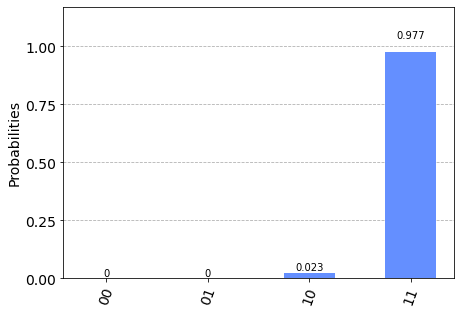

In [12]:
gate_set,coeff_set=mycx_sample(1,200000)
backend = Aer.get_backend('qasm_simulator')
totalcount=dict()
print(totalcount)
print('start')
sum=0
for set in gate_set.keys():
    qc=QuantumCircuit(3,2)
    qc.x(0)
    subqc=circuits[int(set)]
    append_cnot(qc,subqc,[0,1,2])
    qc.measure([0,1],[0,1])
    qc_noisy = insert_noise(qc, noise_model)
    job = execute(qc_noisy, backend, shots=gate_set[set])
    counts = job.result().get_counts(qc_noisy)
    #print('result of',set,':',counts)
    #print('coeff:',coeff_set[set])
    #print('before addition:',totalcount)
    for data in counts:
        if data in totalcount.keys():
            if coeff_set[set] == 1:
                totalcount[data] += counts[data]
            elif coeff_set[set] == -1:
                totalcount[data] -= counts[data]
        else:
            if coeff_set[set] == 1:
                totalcount[data] = counts[data]
            elif coeff_set[set] == -1:
                totalcount[data] = -counts[data]

    #print('after addition:',totalcount)
    #print('next')
print(totalcount)
for key, value in totalcount.items():
    if value<0:
        totalcount[key] = 0
plot_histogram(totalcount)
    
    

{'11': 97057, '10': 2943}


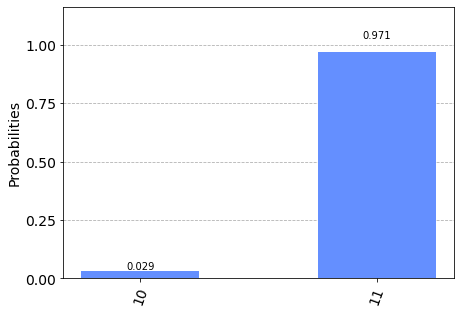

In [9]:
backend = Aer.get_backend('qasm_simulator')

qc=QuantumCircuit(3,2)
qc.x(0)
qc.cnot(0, 1)
qc.measure([0,1],[0,1])

qc_noisy = insert_noise(qc, noise_model)
job = execute(qc_noisy, backend, shots=100000)
counts = job.result().get_counts(qc_noisy)

print(counts)
plot_histogram(counts)

{}
start


C:\Users\jack_\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  after removing the cwd from sys.path.
C:\Users\jack_\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  # This is added back by InteractiveShellApp.init_path()


{'01': 249184, '10': -34, '11': -8606, '00': 166}


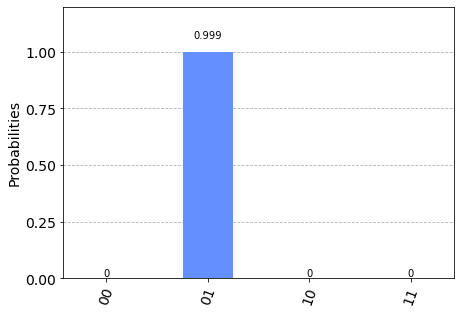

In [10]:
gate_set,coeff_set=mycx_sample(2,400000)
backend = Aer.get_backend('qasm_simulator')
totalcount=dict()
print(totalcount)
print('start')
sum=0
for set in gate_set.keys():
    circ=set.split()
    qc=QuantumCircuit(3,2)
    qc.x(0)
    for i in range(len(circ)):
        append_cnot(qc,circuits[int(circ[i])],[0,1,2])
    qc.measure([0,1],[0,1])
    qc_noisy = insert_noise(qc, noise_model)
    job = execute(qc_noisy, backend, shots=gate_set[set])
    counts = job.result().get_counts(qc_noisy)
    #print('result of',set,':',counts)
    #print('coeff:',coeff_set[set])
    #print('before addition:',totalcount)
    for data in counts:
        if data in totalcount.keys():
            if coeff_set[set] == 1:
                totalcount[data] += counts[data]
            elif coeff_set[set] == -1:
                totalcount[data] -= counts[data]
        else:
            if coeff_set[set] == 1:
                totalcount[data] = counts[data]
            elif coeff_set[set] == -1:
                totalcount[data] = -counts[data]

    #print('after addition:',totalcount)
    #print('next')
print(totalcount)
for key, value in totalcount.items():
    if value<0:
        totalcount[key] = 0
plot_histogram(totalcount)

{'01': 94119, '10': 2848, '00': 2935, '11': 98}


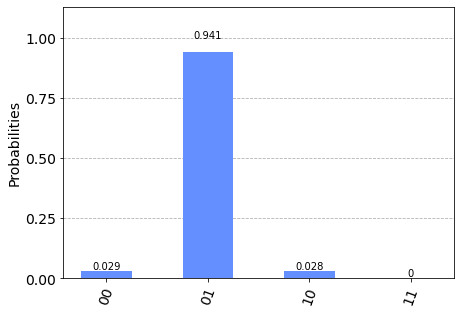

In [11]:
backend = Aer.get_backend('qasm_simulator')

qc=QuantumCircuit(3,2)
qc.x(0)
qc.cnot(0, 1)
qc.cnot(0, 1)
qc.measure([0,1],[0,1])

qc_noisy = insert_noise(qc, noise_model)
job = execute(qc_noisy, backend, shots=100000)
counts = job.result().get_counts(qc_noisy)

print(counts)
plot_histogram(counts)